# Predictive Modeling Order Volume 
## Introduction
One of Kepler's clients, Shazamazon, is an eCommerce retail store selling custom-made thingamabobs. Kepler's media team has been tasked with driving more Shazamazon orders to help them get a bigger foothold in the market. But before we start spending our client's money on advertising, we want to better understand what sorts of customer behaviors drive order volume so that our media team can target the most impactful parts of the customer journey.
 
At Kepler's request, Shazamazon provided the attached data set showing daily order volume across each of their target regions, along with the number of emails customers have opened, the average purchase value for each order, the number of social media likes, and the number of website visits. Despite being a retail provider, Shazamazon has confirmed that they never see seasonal variations in order volume, nor do they see any meaningful difference across regions.
 
As part of the Data Science team, you have been tasked with making sense of this data. Please create a model from this data set that can be used to predict order volume.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import scale
import scipy.stats as stats
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
import datetime as dt

In [2]:
# import data
df = pd.read_csv("Take_Home_Assignment_Data.tsv", sep="\t", parse_dates = ['date'])
df.tail()

,date,region_id,email_opens,avg_order_value,social_likes,total_site_visits,total_orders
7315,2020-12-31,16,7084,26.11,793,201683,722
7316,2020-12-31,17,3702,14.29,115,91973,641
7317,2020-12-31,18,13466,34.73,421,404198,1144
7318,2020-12-31,19,6955,13.95,908,226092,789
7319,2020-12-31,20,2648,9.64,623,68220,434


In [3]:
# dataset shape
df.shape

(7320, 7)

In [4]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320 entries, 0 to 7319
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               7320 non-null   datetime64[ns]
 1   region_id          7320 non-null   int64         
 2   email_opens        7320 non-null   int64         
 3   avg_order_value    7320 non-null   float64       
 4   social_likes       7320 non-null   int64         
 5   total_site_visits  7320 non-null   int64         
 6   total_orders       7320 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 400.4 KB


In [5]:
# dataset describe
df.describe()

,region_id,email_opens,avg_order_value,social_likes,total_site_visits,total_orders
count,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000
mean,10.500000,8381.830328,29.277234,591.775956,209482.984290,775.732787
std,5.766675,3841.843843,14.002776,305.971973,94113.362019,229.997818
min,1.000000,917.000000,4.870000,63.000000,23679.000000,3.000000
25%,5.750000,5623.000000,17.177500,322.000000,142852.000000,622.000000
50%,10.500000,7864.500000,29.260000,592.500000,199202.000000,774.000000
75%,15.250000,10635.250000,41.502500,856.000000,267722.750000,929.000000
max,20.000000,28229.000000,53.240000,1121.000000,715657.000000,1689.000000


## EDA

### Missing Value Check

In [6]:
# missing values each features
missing_values = df.isnull().sum()
missing_values

date                 0
region_id            0
email_opens          0
avg_order_value      0
social_likes         0
total_site_visits    0
total_orders         0
dtype: int64

*This dataset has absolutely no missing values. In reality, this is a rare case. It is the biggest and most important part of EDA.*

### Correlation Coeffiencts

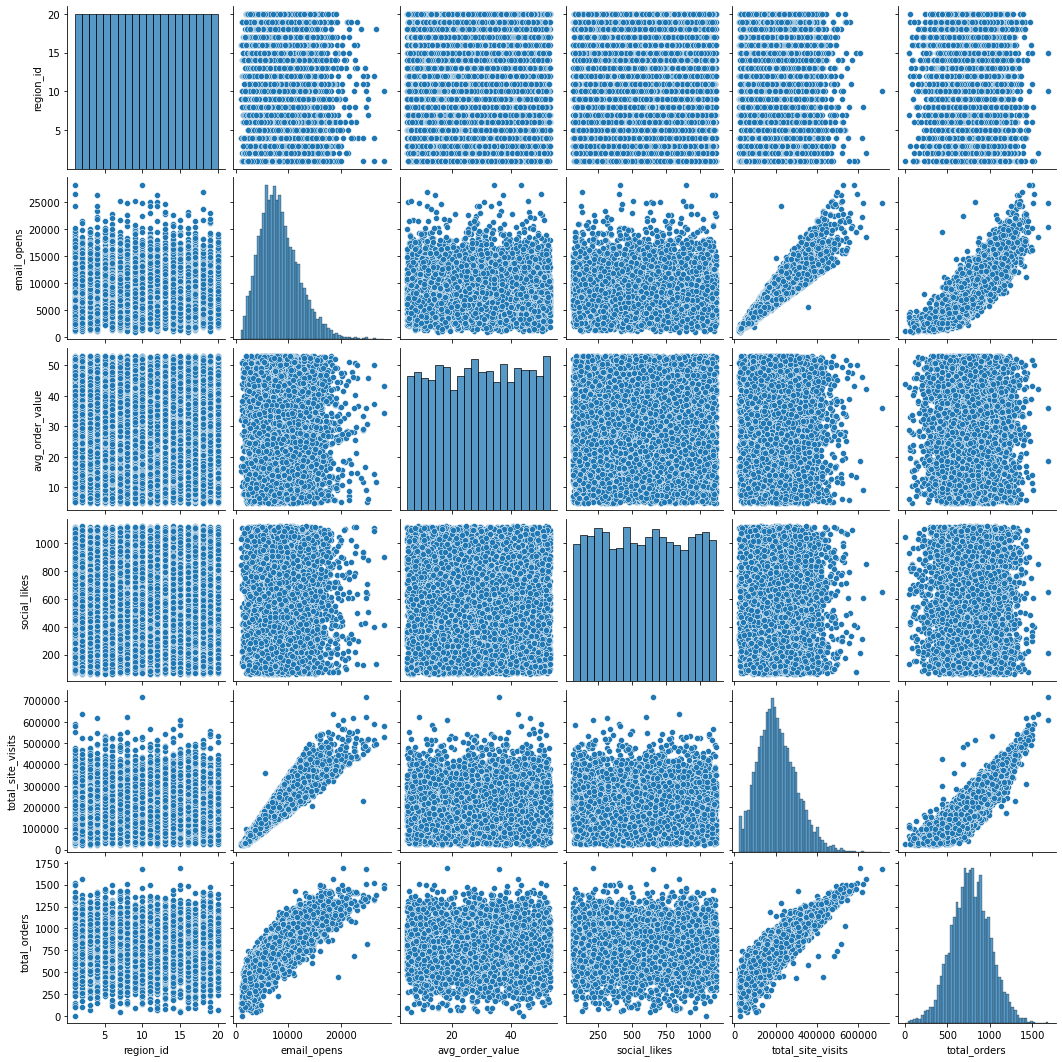

In [7]:
sns.pairplot(df)

<AxesSubplot:>

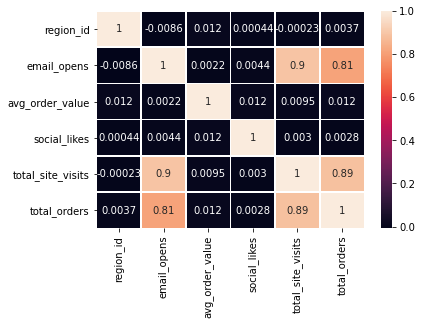

In [8]:
sns.heatmap(df.corr(), linewidth=0.5, annot=True)

In [9]:
corr_matrix = df.corr()
corr_matrix["total_orders"].sort_values(ascending=False)

total_orders         1.000000
total_site_visits    0.887381
email_opens          0.813354
avg_order_value      0.011862
region_id            0.003726
social_likes         0.002765
Name: total_orders, dtype: float64

**total_site_visits and email_opens are overwhelmingly highly correlated with total_orders. Obviously, it can be seen that total_site_visits and email_opens induce an increase in total_orders.**

*Correlation Coefficents are how strong a relationship is between two variables.*
- **1** indicates a strong positive relationship.
- **-1** indicates a strong negative relationship.
- A result of zero indicates no relationship at all.

### Reconfirmed that there are no seasonal variations in order volume and no differences across regions.

In [10]:
df_region = df.copy()
df_region = df_region.groupby(['region_id'])['total_orders'].sum().reset_index()
df_region

,region_id,total_orders
0,1,278920
1,2,280464
2,3,284637
3,4,280983
4,5,293910
5,6,287224
6,7,280268
7,8,281320
8,9,284295
9,10,283659


Text(0, 0.5, 'Total Orders')

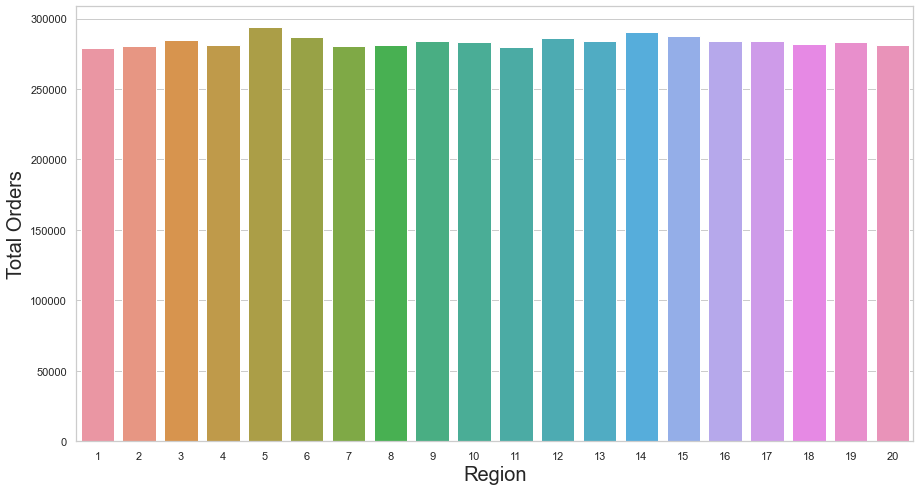

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='region_id', y='total_orders', data=df_region)
ax.set_xlabel("Region", fontsize = 20)
ax.set_ylabel("Total Orders", fontsize = 20)

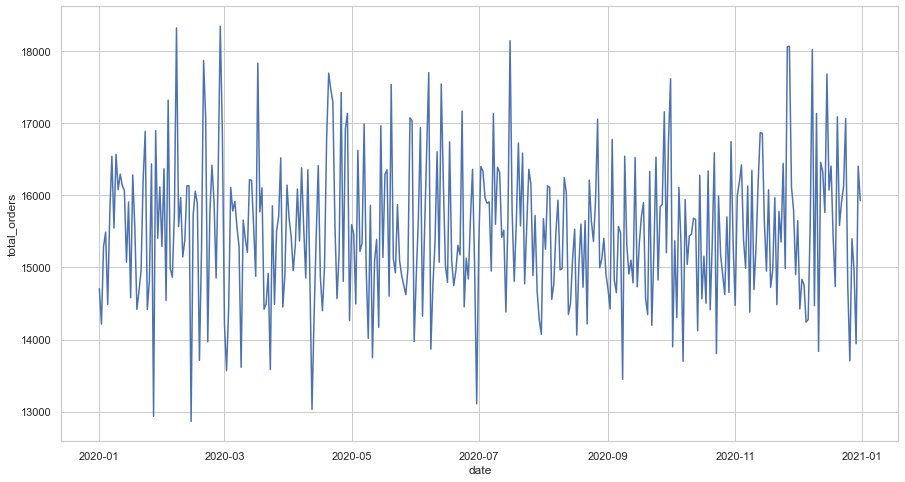

In [12]:
df_date = df.copy()
df_date = df_date.groupby(['date'])['total_orders'].sum().reset_index()
sns.lineplot(x='date',y='total_orders',data=df_date);

*As a result, it is confirmed that there is no seasonal variation and there is no significant difference across regions.*

## Detect Outliers

<AxesSubplot:xlabel='region_id', ylabel='total_orders'>

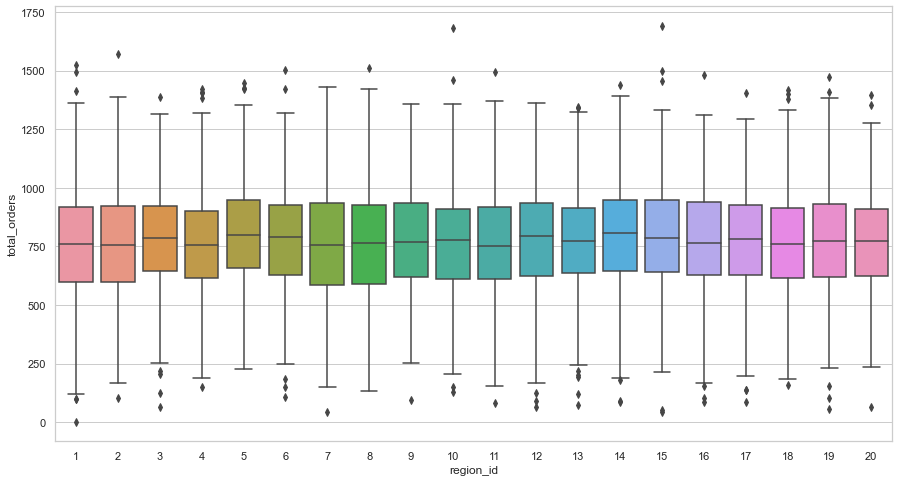

In [13]:
sns.boxplot(x = df['region_id'], y = df['total_orders'])

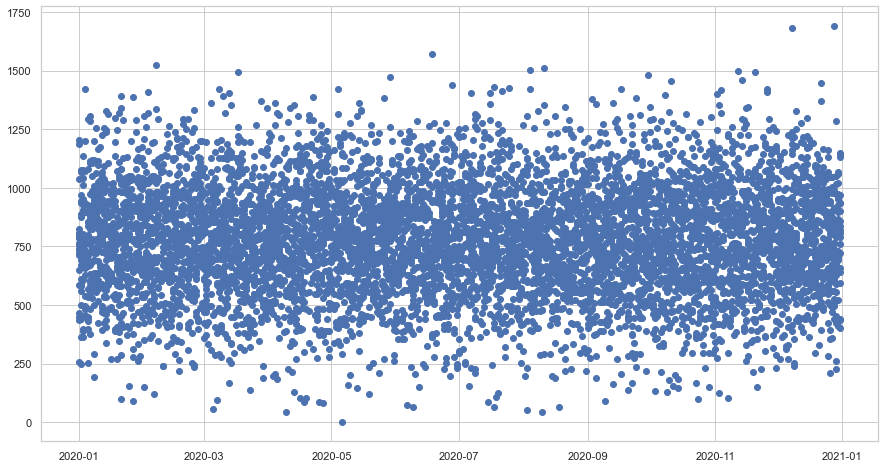

In [14]:
plt.scatter(x=df.date, y=df.total_orders)
plt.show()

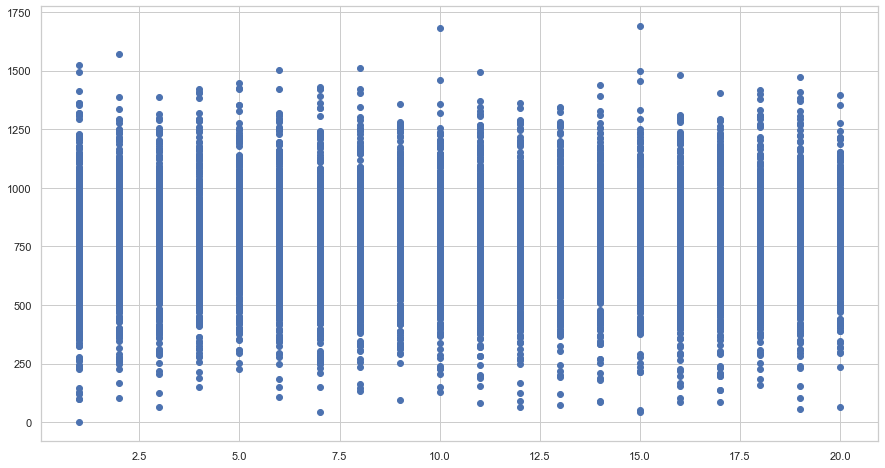

In [15]:
plt.scatter(x=df.region_id, y=df.total_orders)
plt.show()

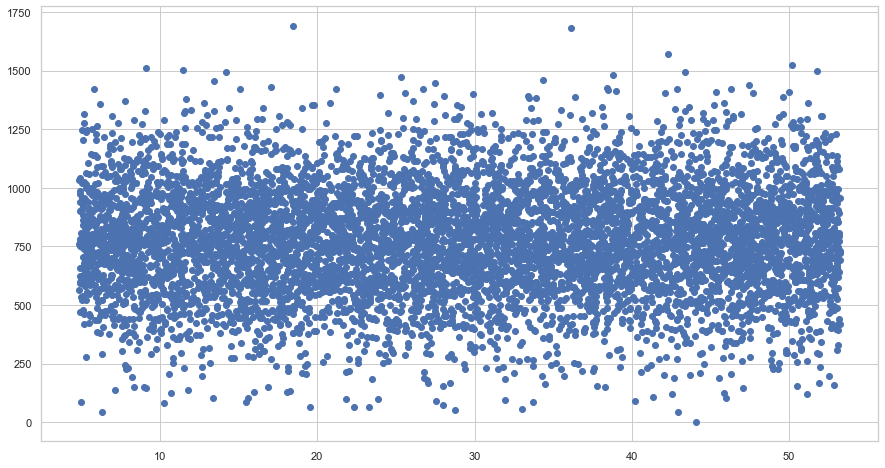

In [16]:
plt.scatter(x=df.avg_order_value, y=df.total_orders)
plt.show()

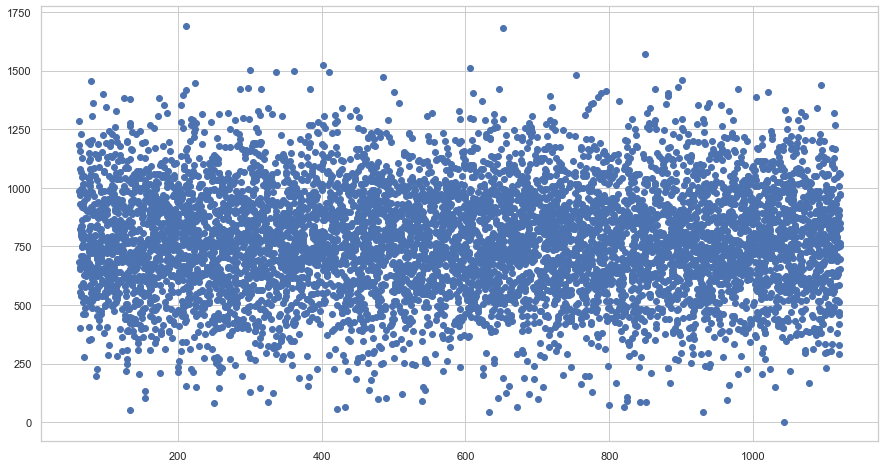

In [17]:
plt.scatter(x=df.social_likes, y=df.total_orders)
plt.show()

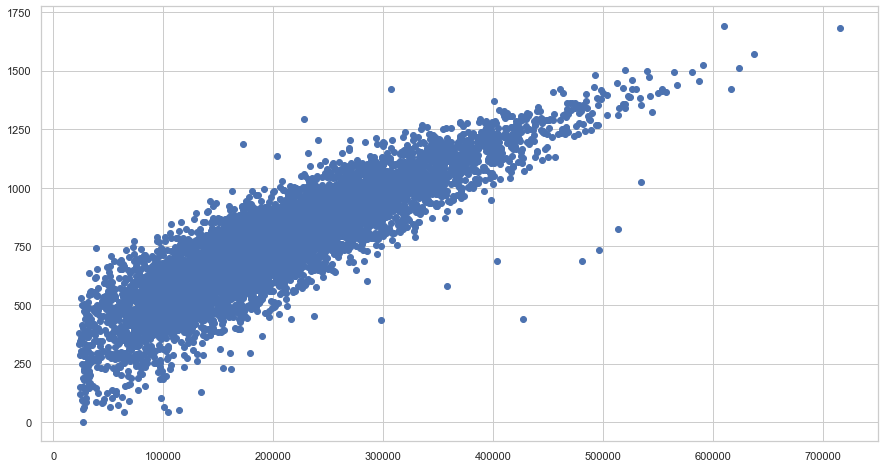

In [18]:
plt.scatter(x=df.total_site_visits, y=df.total_orders)
plt.show()

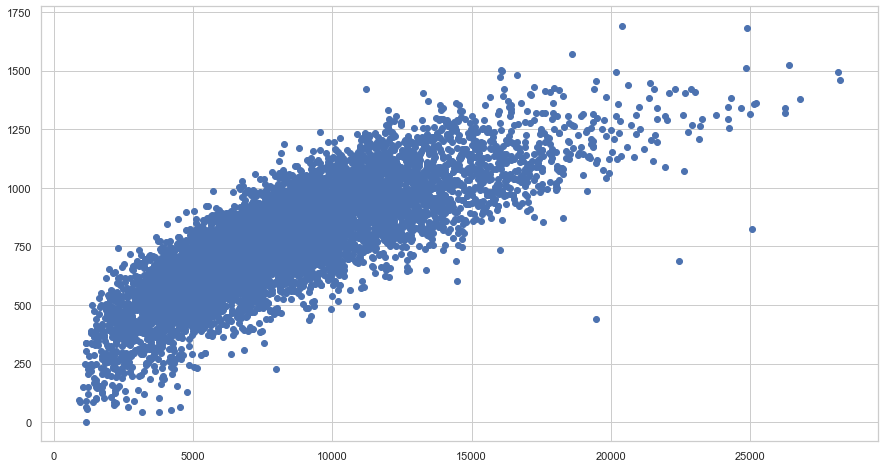

In [19]:
plt.scatter(x=df.email_opens, y=df.total_orders)
plt.show()

In [20]:
indexNames = df[ (df.total_orders < 250) | (df.total_orders > 1500) ].index
df.drop(indexNames , inplace=True)
df.shape

(7216, 7)

## Skew data

0        464
1        739
2        737
3        786
4        712
        ... 
7315     722
7316     641
7317    1144
7318     789
7319     434
Name: total_orders, Length: 7216, dtype: int64


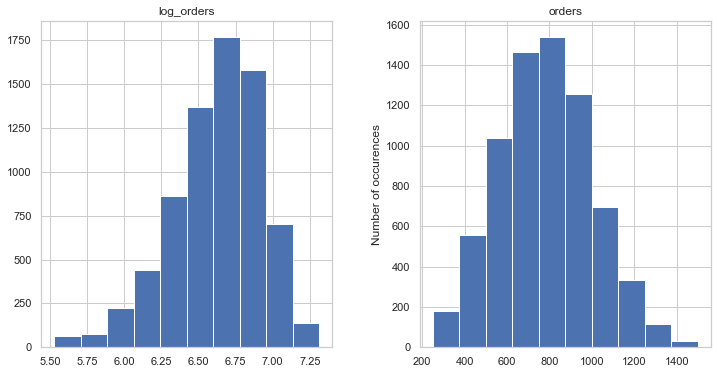

In [21]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
orders = pd.DataFrame({'log_orders':np.log1p(df["total_orders"]), 'orders': df["total_orders"]})
orders.hist()
plt.ylabel('Number of occurences')
print(df.total_orders)

In [22]:
print(np.log1p(df["total_orders"]).skew())
print(df["total_orders"].skew())

-0.6645137420558161
0.1570837969827811


**I will not do log transformation when log transformation is more skewed.**

# Machine Learning

In [23]:
# set predictor variable and target variable
y = df['total_orders']
X = df.drop(['total_orders'], axis=1)
# Convert datetime to apply machine learning
X['date'] = X['date'].map(dt.datetime.toordinal)

In [24]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 465)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4834, 6)
(4834,)
(2382, 6)
(2382,)


In [26]:
X_add_const = sm.add_constant(X_train)
results = sm.OLS(y_train, X_add_const).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_orders   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     2985.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:56:27   Log-Likelihood:                -29181.
No. Observations:                4834   AIC:                         5.838e+04
Df Residuals:                    4827   BIC:                         5.842e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3622.1162   1.02e+04     -0.355      0.723   -2.36e+04    1.64e+04
date                  0.0054      0.014      0.387      0.699      -0.022       0.032
region_id             0.3494      0.254      1.378      0.168      -0.148       0.847
email_opens           0.0058      0.001      6.722      0.000       0.004       0.007
avg_order_value      -0.0275      0.104     -0.264      0.792      -0.232       0.177
social_likes          0.0002      0.005      0.040      0.968      -0.009       0.010
total_site_visits     0.0019   3.52e-05     53.928      0.000       0.002       0.002
==============================================================================
Omnibus:                      330.042   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              759.431
Skew:                          -0.428   Prob(JB):                    1.23e-165
Kurtosis:                       4.743   Cond. No.                     5.38e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.38e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
X_test

,date,region_id,email_opens,avg_order_value,social_likes,total_site_visits
3154,737582,15,11194,41.37,798,338995
3817,737615,18,21639,51.16,652,444926
5507,737700,8,5389,22.60,1118,115155
2539,737551,20,17850,20.46,807,362586
818,737465,19,10596,38.05,273,212698
...,...,...,...,...,...,...
6132,737731,13,14509,11.45,1117,266853
270,737438,11,10490,8.27,752,253200
4310,737640,11,8376,33.95,155,165225
5115,737680,16,12749,27.45,917,240866


In [28]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)
lreg_y_pred = lreg.predict(X_test)
print(lreg.score(X_test,y_test))
print(mean_squared_error(y_test, lreg_y_pred))

0.791732807974085
9877.428065157375


In [29]:
print('y = ' + str(lreg.intercept_) + ' ')
for i, c in enumerate(lreg.coef_):
    print(str(c) + ' * x' + str(i))

y = -3622.116230540076 
0.0053585830697358795 * x0
0.34944136161492667 * x1
0.005764144902631139 * x2
-0.027531986680644837 * x3
0.00018973927164358625 * x4
0.0019008713478966186 * x5


In [30]:
## Testing using only highly correlated features
df_high = df.copy()
y_high = df_high['total_orders']
X_high = df_high[['email_opens', 'total_site_visits']]

In [31]:
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size = 0.33, random_state = 465)

In [32]:
print('Training Data Count: {}'.format(X_train_high.shape))
print('Testing Data Count: {}'.format(X_test_high.shape))

Training Data Count: (4834, 2)
Testing Data Count: (2382, 2)


In [33]:
X_train_high = sm.add_constant(X_train_high)
results = sm.OLS(y_train_high, X_train_high).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_orders   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     8959.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:56:27   Log-Likelihood:                -29182.
No. Observations:                4834   AIC:                         5.837e+04
Df Residuals:                    4831   BIC:                         5.839e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               333.3360      3.677     90.658      0.000     326.128     340.544
email_opens           0.0057      0.001      6.706      0.000       0.004       0.007
total_site_visits     0.0019   3.52e-05     53.999      0.000       0.002       0.002
==============================================================================
Omnibus:                      330.143   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.284
Skew:                          -0.428   Prob(JB):                    4.89e-166
Kurtosis:                       4.746   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Although a model was created using only two features with high correlation, almost the same results were obtained as a model to which all six features were applied. Although there are some differences in the details, it can be seen that email_opens and total_site_visitors almost determine the model.**

## Regularization with pipeline

In [34]:
regressions = [
    LinearRegression(), 
    Lasso(), 
    Ridge(), 
    ElasticNet(), 
    SVR(), 
    XGBRegressor(), 
    RandomForestRegressor(), 
    GradientBoostingRegressor(), 
    KNeighborsRegressor()]

LinearRegression()
0.7917328079740849
9877.428065157379
Lasso()
0.7918971822113904
9869.632335599801
Ridge()
0.7917277302693901
9877.668883993847
ElasticNet()
0.7374839026445403
12450.275256276342
SVR()
0.6101451829546768
18489.531998593
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
0.7679538435569466
11005.186154223053
RandomForestRegressor()
0.7851315050490958
10190.506155583544
GradientBoostingRegressor()
0.7955681069692587
9695.53244557037
KNeighborsRegressor()
0.

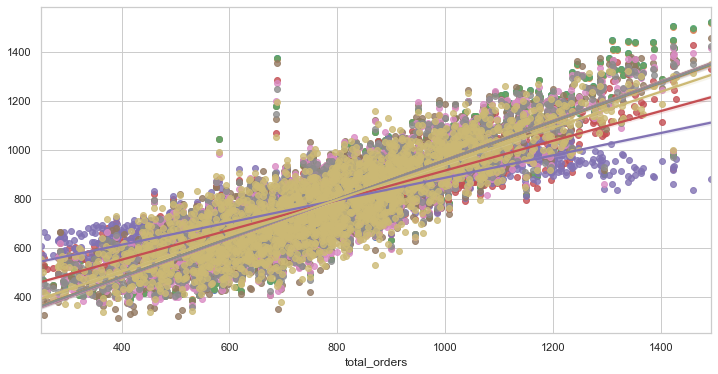

In [35]:
for reg in regressions:
    pipe = Pipeline([('scaler', StandardScaler()), ('reg',reg)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    sns.regplot(y_test,y_pred)
    score = pipe.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(reg)
    print(score)
    print(mse)
    

In [36]:
pipe1 = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('reg', Ridge())])
 
param_grid = {
    'pca__n_components': [2,3,4]
    }
 
gcv = GridSearchCV(pipe1, param_grid, n_jobs=-1)
gcv.fit(X_train, y_train)
 
print('Best Parameter:', gcv.best_params_)
print('Best Score:', gcv.best_score_)

Best Parameter: {'pca__n_components': 4}
Best Score: 0.7609734122163254


**Unfortunately, as a result, LinearRegression() produced the best results. Ridge is known to be the best solution for multicollinearity, so I expected it, but it didn't make much of a difference. It seems that there was a lack in EDA and data preprocessing process. After submission, I will review it carefully again without giving up.**

In [39]:
lreg_y_pred = lreg.predict([[737805, 7, 10449, 48.02, 447, 282887]])
print(lreg_y_pred)

[930.64331129]
